# Modeling

It is often desired to understand the relationship between different sources of information. As an example we'll consider the historical request rate of a web server and compare it to its CPU usage. We'll try to predict the CPU usage of the server based on the request rates of the different pages. First some imports:

In [486]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
pylab.rcParams['figure.figsize'] = (13.0, 8.0)
%matplotlib inline

### Data import and inspection

[Pandas](http://pandas.pydata.org/) is a popular library for data wrangling, we'll use it to load and inspect a csv file that contains the historical web request and cpu usage of a web server:

In [487]:
data = pd.DataFrame.from_csv("data/request_rate_vs_CPU.csv")

The head command allows one to quickly see the structure of the loaded data:

In [488]:
data.head()

,products/science.html,products/non-fiction.html,products/fiction.html,api/comment,api/product/get.php,resources/js/basket.js,CPU
2016-08-21 08:00:00,134.835762,22.753042,35.713667,37.523528,51.146578,25.978119,37.157171
2016-08-21 08:05:00,85.566227,20.918883,27.833613,29.001516,46.606963,19.972983,22.831506
2016-08-21 08:10:00,121.476458,18.470509,42.939950,30.845971,48.326172,25.550460,39.923117
2016-08-21 08:15:00,106.727355,19.734051,28.055008,40.791409,45.765364,25.644494,41.624054
2016-08-21 08:20:00,136.213476,25.699896,40.172650,33.057671,48.259501,16.087842,30.987077


We can select the CPU column and plot the data:

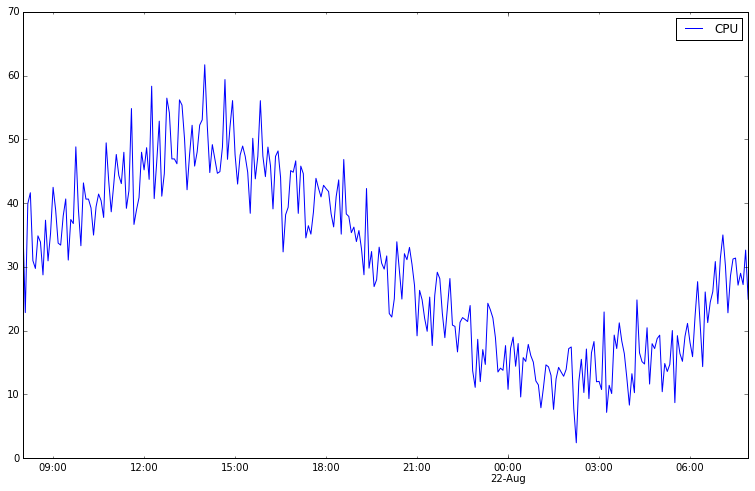

In [489]:
data.plot(figsize=(13,8), y="CPU")

Next we plot the request rates, leaving out the CPU column  as it has another unit:

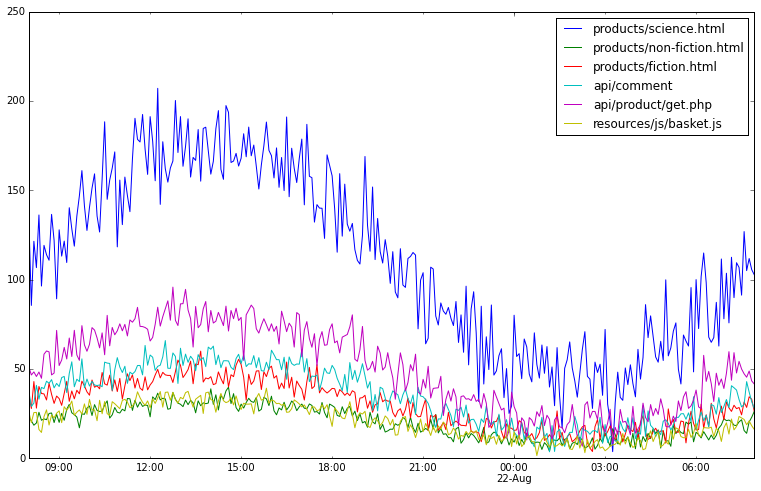

In [490]:
data.drop('CPU',1).plot(figsize=(13,8))

Now to continue and start to model the data, we'll work with basic numpy arrays.

We extract the column labels as the request_names for later reference:

In [491]:
request_names = data.drop('CPU',1).columns.values
request_names

array(['products/science.html', 'products/non-fiction.html',
       'products/fiction.html', 'api/comment', 'api/product/get.php',
       'resources/js/basket.js'], dtype=object)

We extract the request rates as a 2-dimensional numpy array:

In [492]:
request_rates = data.drop('CPU',1).values

and the cpu usage as a one-dimensional numpy array

In [493]:
cpu = data['CPU'].values

### Simple linear regression

First, we're going to work with the total request rate on the server, and compare it to the CPU usage. The numpy function [sum](http://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) can be used to calculate the total request rate when selecting the right direction (axis) for th summation.

In [494]:
# fill in
total_request_rate = np.sum(request_rates, axis=1)

Let's plot the total request rate to check:

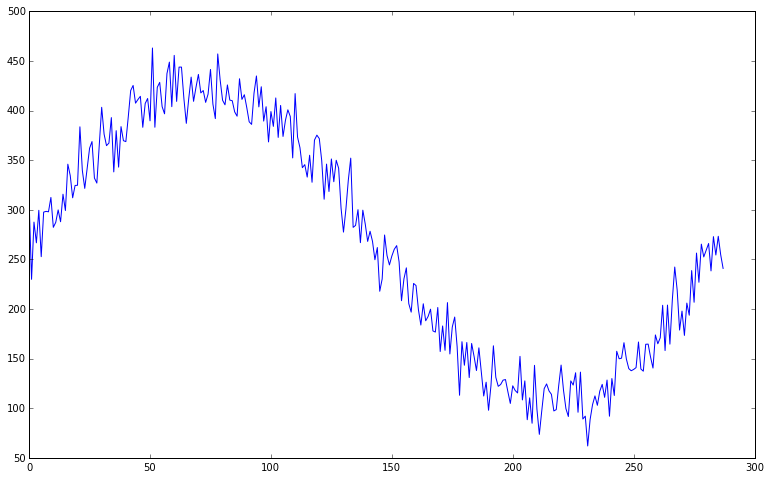

In [495]:
plt.figure(figsize=(13,8))
plt.plot(total_request_rate)

We can make use of a [PyPlot's scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) to understand the relation between the total request rate and the CPU usage:

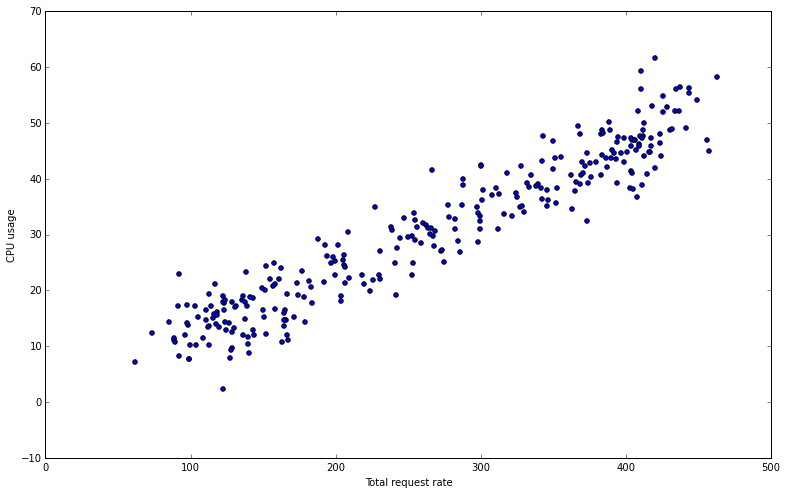

In [496]:
# fill in 
plt.figure(figsize=(13,8))
plt.xlabel("Total request rate")
plt.ylabel("CPU usage")
plt.scatter(total_request_rate, cpu)

There clearly is a strong correlation between the request rate and the CPU usage. Now we'll try to capture this relation using a linear model:
$$ \text{cpu} = c_0 + c_1 \text{total_request_rate} $$

For that we'll make use of the [scikit-learn](http://scikit-learn.org/stable/) machine learning library for Python and use [least-squares linear regression](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

In [497]:
from sklearn import linear_model
model = linear_model.LinearRegression()

Now we need to feed the data to the model to fit it. The model.fit method expects a matrix so we need to convert the total_request_rate into a matrix with one column, we can 
use the [reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) method for that:

In [498]:
# fill in
total_request_rate_M = total_request_rate.reshape((-1,1))

Then we use [model.fit](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) using the the total request rate and cpu.

In [499]:
#fill in
model.fit(total_request_rate_M, cpu)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

We can now inspect the coefficient $c_1$ of the model:

In [500]:
model.coef_

array([ 0.11271075])

And the constant term $c_0$:

In [501]:
model.intercept_

0.72428310668012941

Once the model is trained we can use it to [predict](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) the outcome for a given input (or array of inputs). 

What is the expected CPU usage when we have 50 requests per second? At how many requests/s will we reach 100% cpu ?

In [526]:
# fill in 
model.predict(50)

model.predict(999)

array([ 113.32232579])

Now we plot the linear model together with our data to verify it caputes the relationship correctly

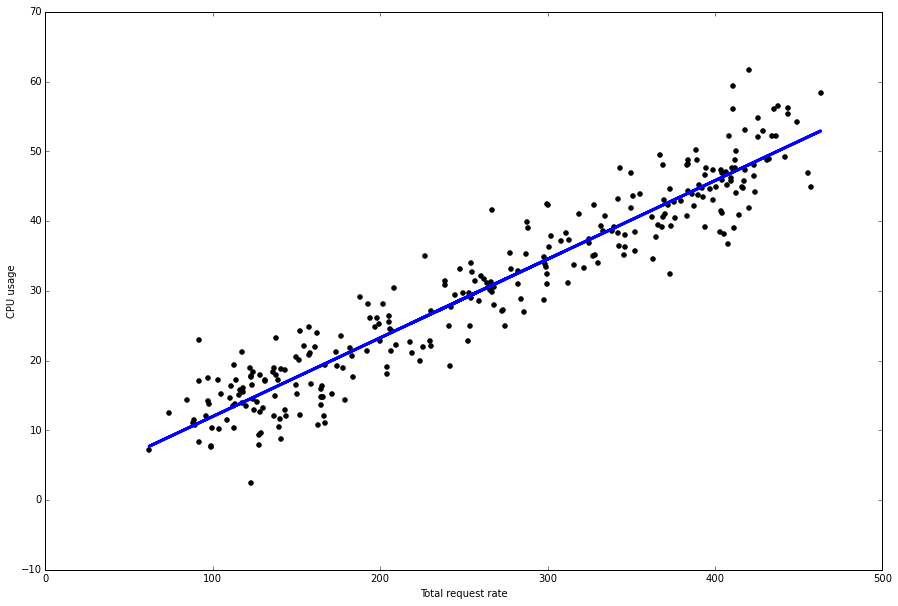

In [530]:
# fill in
plt.figure(figsize=(15,10))
plt.scatter(total_request_rate, cpu,  color='black')
plt.plot(total_request_rate, model.predict(total_request_rate_M), color='blue', linewidth=3)
plt.xlabel("Total request rate")
plt.ylabel("CPU usage")

plt.show()

Our model also has a [score](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) indicating how well the linear model captures the data. A score of 1 means the data is perfectly linear, a score of 0 (or lower) means the data is not linear at all (and it does not make sense to try to model it that way).

In [531]:
model.score(total_request_rate_M, cpu)

0.90479192980248935

### Multiple linear regression

Now we consider the separate request rates again and build a linear model for that. The model we try to fit takes the form:
$$\text{cpu} = c_0 + c_1 \text{request_rate}_1 + c_2 \text{request_rate}_2 + \ldots + c_n \text{request_rate}_n$$
where the $\text{request_rate}_i$'s correspond the our different requests:


In [532]:
request_names

array(['products/science.html', 'products/non-fiction.html',
       'products/fiction.html', 'api/comment', 'api/product/get.php',
       'resources/js/basket.js'], dtype=object)

No we create a new [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) model.

In [533]:
# fill in
multi_lin_model = linear_model.LinearRegression(fit_intercept=False)

Next fit the model on the data:

In [534]:
# fill in
multi_lin_model.fit(request_rates, cpu)

LinearRegression(copy_X=True, fit_intercept=False, normalize=False)

Which request causes most CPU usage, on a per visit basis? ([np.argmax](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) finds the index of the greatest element in an array)

In [535]:
#fill in 
heavy_request = request_names[np.argmax(multi_lin_model.coef_)]
print heavy_request

resources/js/basket.js


If we want to minimize average CPU usage on this server by deviating traffic of one webpage to another server, which page should we choose?  
One way to determine this is by using the multi_lin_model.predict method. Another way is by directly using the regression formula. Some functions that might be useful for this:
- [np.mean](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) can used to calculate the mean of the values in a matrix
- a * b will calculate the pairwaize product of two vectors

In [536]:
# fill in
average_rates = np.mean(request_rates, axis=0)
request_to_move = request_names[np.argmax(multi_lin_model.coef_ * average_rates)]
print request_to_move

api/product/get.php
